# **Malaria Detection**

# **Problem Definition**

## **Context:**
Malaria is a contagious disease caused by parasites that are transmitted through the bites of infected mosquitoes. The parasites enter the blood and begin damaging red blood cells (RBCs) that carry oxygen, which can result in respiratory distress and other complications. Late treatment can cause complications and could even be fatal, but as the symptoms can mimic the flu and stay dormant for a year or more, **early detection is key**.

Malaria is known as a **disease of poverty**. Dispite treatment being **highly effective** and **relitively inexpensive**, almost 50% of the world’s population continues to be at risk from malaria. There were more than 229 million malaria cases and 400,000 malaria-related deaths reported over the world in 2019. This challenge primarly stems from **bottle necks that make early detection difficult in poorer parts of the world.**

* Collecting blood samples requires the use of large and heavy centrigue and microscope, often in remote areas that do not have access to electricity.
* **Diagnosis of those samples requires inspection by experience professionals (which also needs to be factored into the cost). Given the magnitude of the problem, this is a repetitive and time-consuming process.**

While the first problem has largely been solved through inspired inovation (paperfuge and foldscope), the second continues to be a issue. An automated model can be an innovative solution to that problem. Not only providing **faster** and **cheaper** diagnosises, but also with a **greater accuracy** than the varriation found with professionals.

In the words of Manu Prakash form Stanfords frugal labs, and the inventor of foldscope and paperfuge:

"Every 0 that you add to the cost of scientific equipment, probably thousands and millions of people cut off"

An automated system using machine learning to perform malaria detection has the potential to have **tremendous positive impact**. 

##**Objectives:**
Build an efficient computer vision model to detect malaria. The model should identify whether the image of a red blood cell is that of one infected with malaria or not, and classify the same as parasitized or uninfected, respectively.

The 2 standard forms of malaria detection are **Rapid Diagnostic Tests (RDT)** and **Microscopy**. **The goal of this project is to build a computer vision model that is equal to or greater in accuracy than the standard tests.** 
+ Microscopy varies depending on the lab and technician's experience (best case **~98% accuracy**) and considered the gold standard.
+ RDTs on the other hand are less accurate (**~88% accuracy**) but cheaper and therefore more widely used.

If possible, we want to optimize for **recall** as the cost of a false negative could potentially lead to death, while there is little risk of false positives (malaria drugs have minor side effects and it is likely that patients would be tested a second time to confirm)

## **Problem Formulation**
With an average of 2000 cases in the United States yearly, malaria is not highly present in the western world. The in-frequency of cases is a known problem for microscopic detection, as labs in the **developed world** do not see many cases, and therefore technicians have less experience. There is, therefore, a **potential use case** for a computer vision model that could perform more reliably and cheaply.

However, with an estimated global 241 million cases and 672 thousand deaths in 2020, the more relevant use case for a computer vision model is in the **developing world** where the disease is significantly more prevalent and deadly. A new technology that can improve both accuracy and cost is especially impactful where Microscopy is less available, and cost is a limiting factor.

## **Key Questions:** 
* Note observations on the images
  * What features could the model potential recognize to classify parasitized and uninfected cells?
  * What features coudl potentially cause error in the model?
* Test different types of image transformations, which would increase the models accuracy?
* What are some potential model design solutions, and how do we measure if they are overall sucessfull?
* How do different techniques and model architectures perform?
* Which is performing relatively better?
* Is there scope to improve the performance further?
* What model should be adopted?

## **Data Description**

There are a total of 24,958 train and 2,600 test images (colored) that we have taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


# **Loading Data**

### **Mounting the Drive**

In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### <b>Loading libraries</b>

In [ ]:
# Importing libraries required to load the data
import zipfile
import os
from PIL import Image

# Basics
import numpy as np
import pandas as pd

#Data Vizualizaiton
import matplotlib.pyplot as plt
import seaborn as sns

#Model Building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model # Sequential api for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten # Importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU, Activation
from tensorflow.keras import backend 
from tensorflow.keras.utils import to_categorical # To perform one-hot encoding
from tensorflow.keras.optimizers import RMSprop, Adam, SGD # Optimizers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  # Regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import load_img
from google.colab.patches import cv2_imshow

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Let us load the data</b>

In [ ]:
# Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Colab Notebooks/MIT-Deep Learning/Capstone/cell_images.zip'

# The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:

    zip_ref.extractall()

### **Train Folder**

In [ ]:
# Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

# Size of image so that each image has the same size
SIZE = 64

# Empty list to store the training images after they are converted to NumPy arrays
train_images = []

# Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [ ]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
    
        try:
    
            # Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))

            # Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':
            
                train_labels.append(1)
           
            else:
           
                train_labels.append(0)
        
        except Exception:
       
            pass       

# Converting lists to arrays
train_images = np.array(train_images)

train_labels = np.array(train_labels)

### **Test Folder**

In [ ]:
# Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

# Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

# Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

# Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [ ]:
# We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):

        try:
            # Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            # Resizing each image to (64, 64)
            image = image.resize((SIZE, SIZE))
            
            # Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            # Creating labels for parasitized and uninfected images
            if folder_name == '/parasitized/':

                test_labels.append(1)

            else:

                test_labels.append(0)

        except Exception:

            pass       

# Converting lists to arrays
test_images = np.array(test_images)

test_labels = np.array(test_labels)

###<b> Checking the shape of train and test images

In [ ]:
# Shape of images
print('Shape of train images: ', train_images.shape)
print('Shape of test images: ', test_images.shape)

Shape of train images:  (24958, 64, 64, 3)
Shape of test images:  (2600, 64, 64, 3)


###<b> Checking the shape of train and test labels

In [ ]:
# Shape of labels 
print('Shape of train labels: ', train_labels.shape)
print('Shape of test labels: ', test_labels.shape)

Shape of train labels:  (24958,)
Shape of test labels:  (2600,)


#### **Observations and insights:**
* We can see that all images where loaded (24,958 train images 2,600 test images)
* We can see that the test and train images where properly converted to 64 by 64 pixel images, including the 3rd dimension for color (RGB)
*  We can see that all labels where loaded (equal to the number of images) to represent positive or negative malaria cases (0 - uninfected, 1 - parasitized).


### <b>Check the minimum and maximum range of pixel values for train and test images

In [ ]:
print('Train images minimum range pixels values: ', train_images.min())
print('Train images maximum range pixels values: ', train_images.max())
print()
print('Test images minimum range pixels values: ', test_images.min())
print('Test images maximum range pixels values: ', test_images.max())

Train images minimum range pixels values:  0
Train images maximum range pixels values:  255

Test images minimum range pixels values:  0
Test images maximum range pixels values:  255


#### **Observations and insights:**
The range of pixel values (intensity of pixels) for most basic images follow a 8-bit system, giving a range of values from 0 to 255. We can see our images correctly fall in that range.


###<b> Count the number of values in both uninfected and parasitized 

In [ ]:
from pandas.core.base import value_counts

print("Number of uninfected(0) and parasitized(1) cases in the training data")
print(value_counts(train_labels))

print()

print("Number of uninfected(0) and parasitized(1) cases in the testing data")
print(value_counts(test_labels))

Number of uninfected(0) and parasitized(1) cases in the training data
1    12582
0    12376
dtype: int64

Number of uninfected(0) and parasitized(1) cases in the testing data
1    1300
0    1300
dtype: int64


###<b>Normalize the images

In [ ]:
from tables.tests.test_suite import test
train_images = (train_images/255).astype('float32')

test_images = (test_images/255).astype('float32')

In [ ]:
# Recheck the range of range of pixel values to confirm the images have been normalized

print('Train images minimum range pixels values: ', train_images.min())
print('Train images maximum range pixels values: ', train_images.max())
print()
print('Test images minimum range pixels values: ', test_images.min())
print('Test images maximum range pixels values: ', test_images.max())

Train images minimum range pixels values:  0.0
Train images maximum range pixels values:  1.0

Test images minimum range pixels values:  0.0
Test images maximum range pixels values:  1.0


#### **Observations and insights:** 
We can see that both the training and testing data have a relitively equal number of positive and negative malaria cases, this should give our model a **good balance** to work on.

The data is split so there is roughly **10 times** the number of training data as there is testing data.

Re-printing the range of pixel values is also a good check to make sure our images have been properly normalized.

###<b> Plot to check if the data is balanced

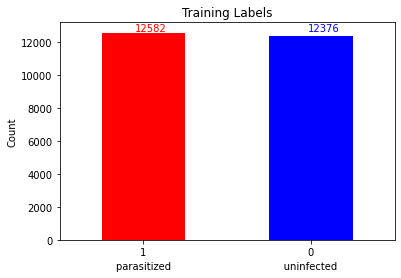

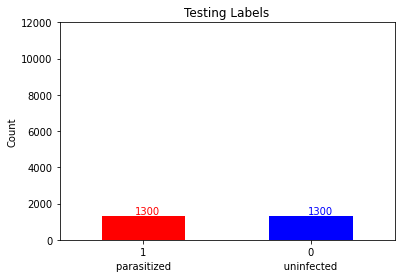

In [ ]:
# TRAINING LABELS ##############################################################

value_counts(train_labels).plot(kind='bar', rot = 0, color = ['red','blue'])

# plt.text() adds the text to the plot
# x and y are positions on the axes
# s is the text to be added
plt.text(x = -0.05, y = value_counts(train_labels)[1]+100, s = value_counts(train_labels)[1], color = 'red')
plt.text(x = 0.98, y = value_counts(train_labels)[0]+300, s = value_counts(train_labels)[0], color = 'blue')

# add title and axes labels
plt.title('Training Labels')
plt.xlabel('parasitized                                    uninfected')
plt.ylabel('Count')

# display the plot
plt.show()

# TESTING LABELS ###############################################################

value_counts(test_labels).plot(kind='bar', rot = 0, color = ['red','blue'])

# plt.text() adds the text to the plot
# x and y are positions on the axes
# s is the text to be added
plt.text(x = -0.05, y = value_counts(test_labels)[1]+100, s = value_counts(test_labels)[1], color = 'red')
plt.text(x = 0.98, y = value_counts(test_labels)[0]+100, s = value_counts(test_labels)[0], color = 'blue')

# add title and axes labels
plt.title('Testing Labels')
plt.xlabel('parasitized                                    uninfected')
plt.ylabel('Count')

# setting y axis to the same range as the training labels so we can observe the scale diference
plt.ylim([0, 12000])

# display the plot
plt.show()


#### **Observations and insights:** 
* The above plots reconfirms our above observation by showing that both the training and testing data have a relitively equal number of positive and negative malaria cases, making our data well balanced.
* It also reiterates that the data is split so there is roughly 10 times the number of training data as there is testing data.



# <b>Data Exploration</b>
Let's visualize the images from the train data

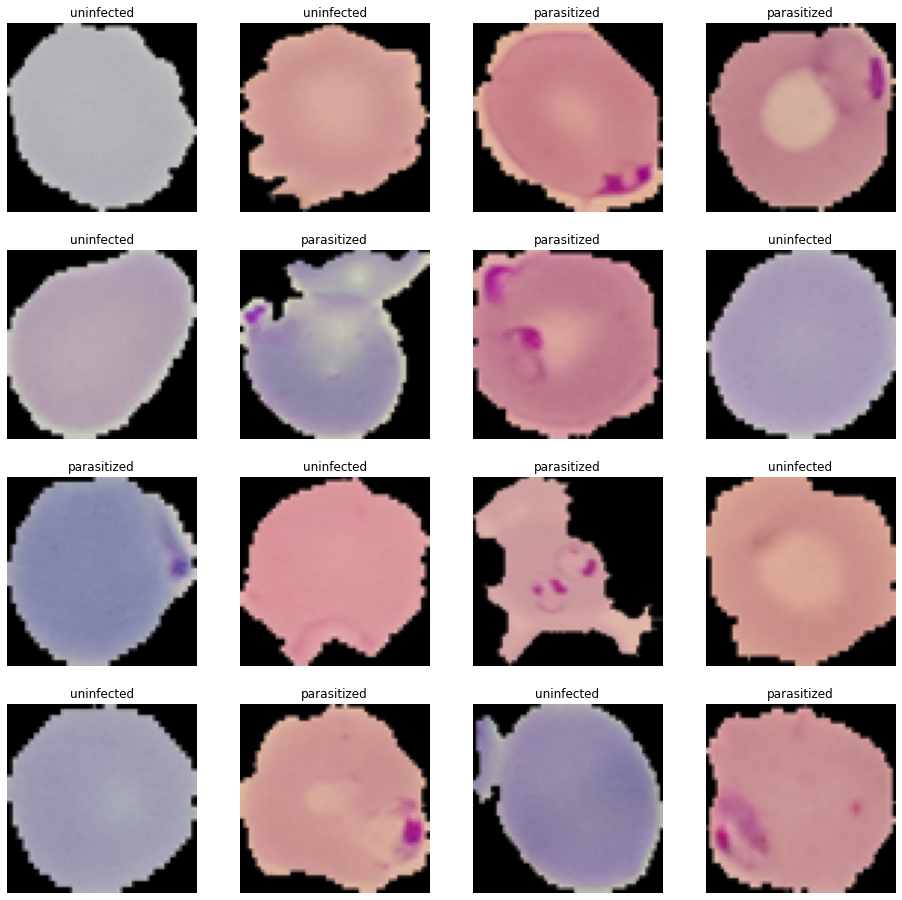

In [ ]:
np.random.seed(42)

plt.figure(1, figsize = (16 , 16))

for n in range(1, 17):

    plt.subplot(4, 4, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1: 

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')

#### **Observations and insights:**
We can see that our data contains images of isolated red blood cells. We can see that some have not been cropped perfectly, but as long as it has not cropped out the infected area this should not be an issue. Also if this model is part of a larger system that weighs at multiple cells in a blood sample, that would mitigate any cropping errors.

They have both blue and pink backgrounds (looks like slightly more pink cells in total). Unsure as to why some have a blue background as most microscope blood smears show pink cells only?

Parasitized cells are identifiable by the presents of parasites in the red blood cells. They can be recognized by:
* **Color** - Taking on a distinct purple hue.
  * This has the potential to cause false positives as some of the uninfected pink cells contain areas of darker color similar to the parasite color.
* **Shape** - The grouping of the parasites tend to form distinct shapes inside of the cell (ring, band, rosette, dots, feathering). These shapes are potentially recognizable in Convolutional Neural Networks using a combination of fiters (edge detections) and pooling.
  * The difference in shape is key in diagnosing the different types of malaria (*Plasmodium falciparum, Plasmodium malariae, Plasmodium ovale, and Plasmodium vivax*). While we are simply looking for positive and negative cases here, there is potential to train future models to also classify the type of malaria present.

###<b> Similarly visualize the images with subplot(6, 6) and figsize = (12, 12)

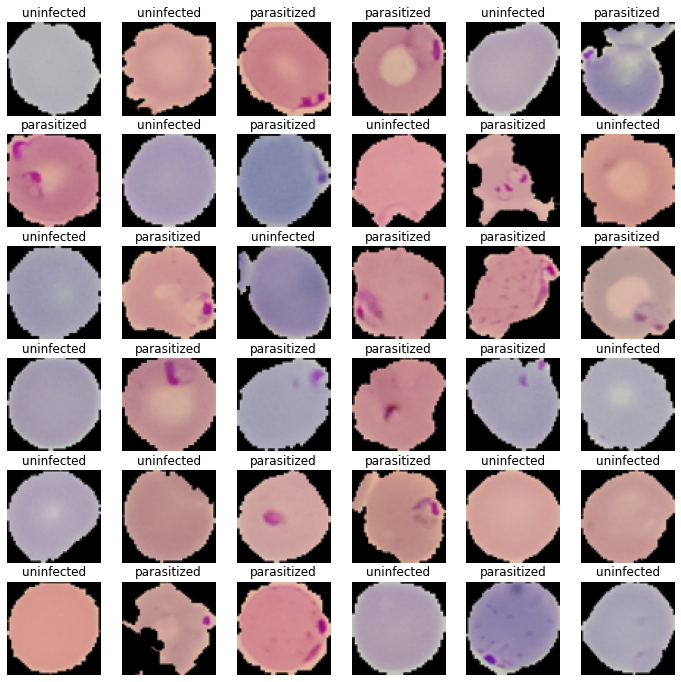

In [ ]:
np.random.seed(42)

plt.figure(1, figsize = (12 , 12))

for n in range(1, 37):

    plt.subplot(6, 6, n)

    index = int(np.random.randint(0, train_images.shape[0], 1))

    if train_labels[index] == 1: 

        plt.title('parasitized')

    else:
        plt.title('uninfected')

    plt.imshow(train_images[index])

    plt.axis('off')


#### **Observations and insights:**
Looking at more exampels we can see:
* there are more variations on the shape of the groups of parasites
* confirmation of more pink uninfected cells containing darker areas
* confirmation of more miss cropped cells, indicating it was not an isolated error
* new is that in the last and third last images we can see what looks like purple specs that would indicate parasites, but both are uninfected. This might indicate the potential for **noise** to give us false positives. 

###<b> Plotting the mean images for parasitized and uninfected

In [ ]:
# Function to find the mean
def find_mean_img(full_mat, title):

    # Calculate the average
    mean_img = np.mean(full_mat, axis = 0)[0]

    # Reshape it back to a matrix
    plt.imshow(mean_img)

    plt.title(f'Average {title}')

    plt.axis('off')

    plt.show()

    return mean_img

<b> Mean image for parasitized

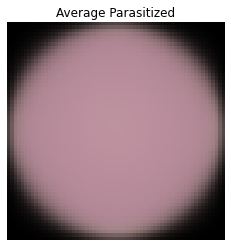

In [ ]:
# If the label = 1 then the image is parasitised and if the label = 0 then the image is uninfected
parasitized_data = []  # Create a list to store the parasitized data

for img, label in zip(train_images, train_labels):

        if label == 1:
              
              parasitized_data.append([img])          

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Parasitized')   # find the mean

<b> Mean image for uninfected

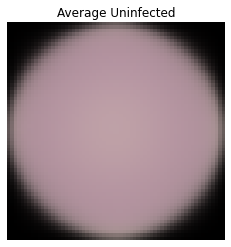

In [ ]:
# If the label = 1 then the image is parasitised and if the label = 0 then the image is uninfected
parasitized_data = []  # Create a list to store the parasitized data

for img, label in zip(train_images, train_labels):

        if label == 0:
              
              parasitized_data.append([img])          

parasitized_mean = find_mean_img(np.array(parasitized_data), 'Uninfected')   # find the mean



#### **Observations and insights:** 

We can see there is very little to distinguish the average parasitized image from the average uninfected image, making it a poor tool to draw any insight. This is not surprising as the majority of the parasitized and uninfected cells are similar in color and shape. Only the presence of the parasites (relitively small area of the cell) is different and that is lost in the blending of colors.  

### <b>Converting RGB to HSV of Images using OpenCV

###<b> Converting the train data

In [ ]:
import cv2

gfx=[]   # to hold the HSV image array

for i in np.arange(0, 100, 1):

  a = cv2.cvtColor(train_images[i], cv2.COLOR_BGR2HSV)
  
  gfx.append(a)

gfx = np.array(gfx)

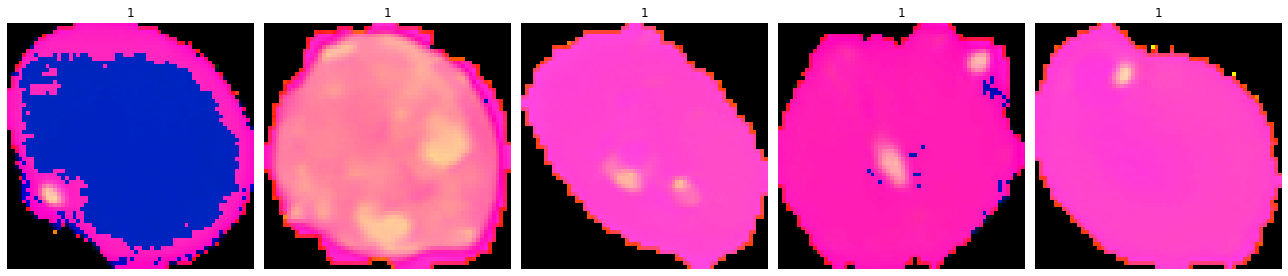

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(gfx[i])

  ax[t].set_axis_off()
  
  fig.tight_layout()

###<b> Converting the test data

In [ ]:
# Similarly you can visualize for the images in the test data
import cv2

gfy=[]   # to hold the HSV image array change to gfy to have a separate location for the test images

for i in np.arange(0, 100, 1):

  a = cv2.cvtColor(test_images[i], cv2.COLOR_BGR2HSV)
  
  gfy.append(a)

gfy = np.array(gfy)

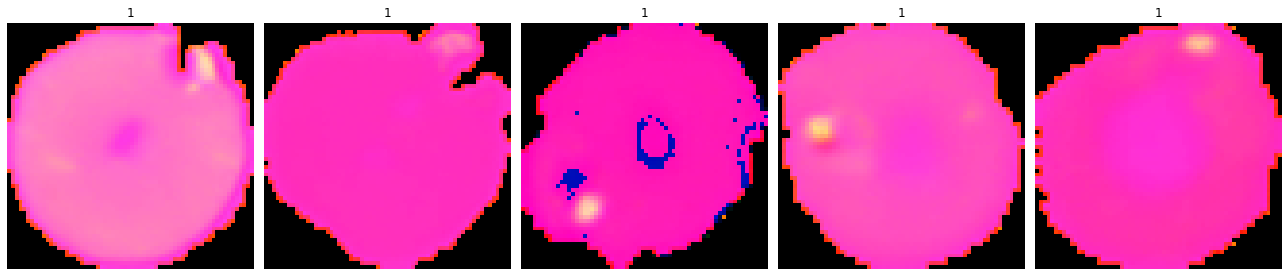

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = test_labels[i]

  ax[t].set_title(Title)

  ax[t].imshow(gfy[i])

  ax[t].set_axis_off()
  
  fig.tight_layout()

#### **Observations and insights:** 
We can see that the HSV images are much more pronounced in their color differences. This would likely proove easier for a neural network to distinguish and therefore result in greater accuracy. 

###<b> Processing Images using Gaussian Blurring

###<b> Gaussian Blurring on train data

In [ ]:
gbx = []  # To hold the blurred images

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(train_images[i], (5, 5), 0)

  gbx.append(b)

gbx = np.array(gbx)

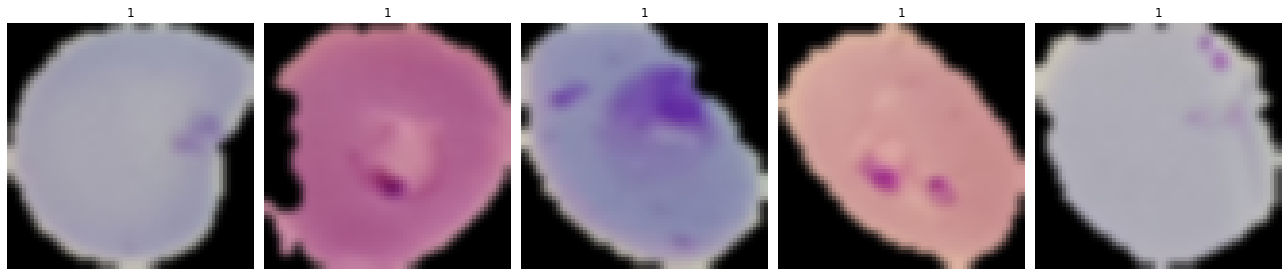

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)

  
  ax[t].imshow(gbx[i])
  
  ax[t].set_axis_off()
  
  fig.tight_layout()

###<b> Gaussian Blurring on test data

In [ ]:
# Similarly you can apply Gaussian blurring for the images in the test data
gby = []  # To hold the blurred images change to gby to have a seperate location for test data

for i in np.arange(0, 100, 1):

  b = cv2.GaussianBlur(train_images[i], (5, 5), 0)

  gby.append(b)

gby = np.array(gby)

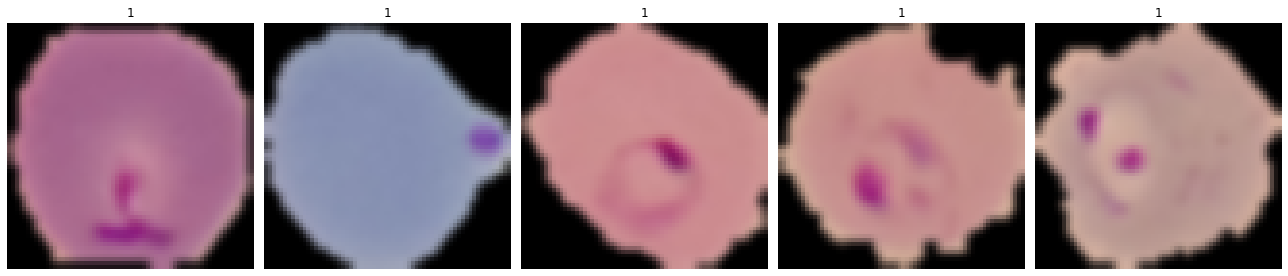

In [ ]:
viewimage = np.random.randint(1, 100, 5)

fig, ax = plt.subplots(1, 5, figsize = (18, 18))

for t, i in zip(range(5), viewimage):

  Title = train_labels[i]

  ax[t].set_title(Title)

  
  ax[t].imshow(gby[i])
  
  ax[t].set_axis_off()
  
  fig.tight_layout()

####**Observations and insights:**
The primary reason for using Gaussian blurring is to **reduce the noise** in images. As we stated above, there is potential for noice to cause false positives in uninfected cells. 

We can still clearly identify the shape and color of parasitic areas, and therefore the reduction in image sharpness may not result in a decrease of accuracy. While the noise reduction can potentially result in an increase in accuracy.

####**Other potential forms of image transformation**
Given that the parasitic areas are generally darker than the colors around it, it would be interesting to see if a model would do well on grayscale images (especially if we could increase contrast to increase that difference). If that could work, it would also decrease the size of the data and potentially save computational resources.

Somewhat counter to gaussian blurring we could also expiriment with increasing the image size to see if the model performs better with more distinct features. 

## **Proposed approach**

**Potential techniques:** 
* As with most image recognition, adding more data will generally increase validation accuracy. 
  * Can be done through finding other databases of labeled malaria images and joining with our current database.
  * Can be done through data augmentation to increase the diversity of our database and potentialy create an even stronger model.
* Of course we could implement some form of transfer learning that generally has positive results on overall accuracy.

<br>It should be noted however that all this comes at the cost of increased complexity and computation. It is generally a good rule to not over enginneer a complex model when a simpler model can achieve the same thing. It is therefore better to fine tune this parameters to find the optimal balance of performance.

**Overall solution design:** 
As we observed above the infected cells can be identified through both color and shape. If color is the primary means of classification, then it is possible that a ANN model would work. However, to take advantage of both a CNN model would likely do much better. 

From there it would be a matter of optimizing the hyperparameters, trying different architectures to see which is best. Before we even begin, we can likely predict that:
* Some pooling layers will be benificial
* Should use the Relu activation function as it performs best for computer vision
* Should consider using recall as our performance metric, as the cost of a false negative could potentially lead to a death. However if we are trying to be conciouse of increased costs from false positives, using accuracy as our performance metric is arguable. 

**Measures of success:** 
Key measures of success will be if we can produce a model that is giving a high accuracy generalized performance. That is to say, the model is not overfitted (does as well or better on the validation data as it does on the training data). 

# **Building The Model**

## **Encoding**

###<B>One Hot Encoding on the train and test labels

In [ ]:
# Encoding Train Labels
train_labels = to_categorical(train_labels, 2)

# Similarly let us try to encode test labels
test_labels = to_categorical(test_labels, 2)

train_labels


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

###<b> Clearing backend and fixing random seed

In [ ]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

## **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

###<b> Building the model_0

In [ ]:
# Creating sequential model
model = Sequential()

#Layer 1
model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

#Layer 2
model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

#Layer 3
model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks 

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train our Model

In [ ]:
# Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history = model.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 96s 152ms/step - loss: 0.4063 - accuracy: 0.8038 - val_loss: 0.1641 - val_accuracy: 0.9319
Epoch 2/20
624/624 [==============================] - 90s 144ms/step - loss: 0.1288 - accuracy: 0.9517 - val_loss: 0.1596 - val_accuracy: 0.9732
Epoch 3/20
624/624 [==============================] - 93s 149ms/step - loss: 0.1015 - accuracy: 0.9683 - val_loss: 0.1326 - val_accuracy: 0.9730
Epoch 4/20
624/624 [==============================] - 94s 150ms/step - loss: 0.0862 - accuracy: 0.9720 - val_loss: 0.0912 - val_accuracy: 0.9858
Epoch 5/20
624/624 [==============================] - 91s 146ms/step - loss: 0.0770 - accuracy: 0.9744 - val_loss: 0.0821 - val_accuracy: 0.9836
Epoch 6/20
624/624 [==============================] - 94s 151ms/step - loss: 0.0701 - accuracy: 0.9768 - val_loss: 0.0949 - val_accuracy: 0.9808
Epoch 7/20
624/624 [==============================] - 90s 144ms/step - loss: 0.0665 - accuracy: 0.9773 - val_loss: 0.0537 - val_ac

###<b> Plotting the validation and training accuracies

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

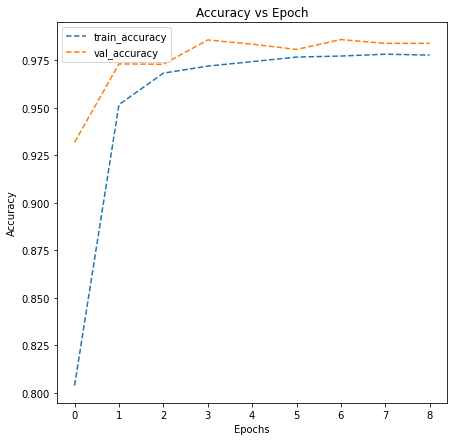

In [ ]:
plot_accuracy(history)

* Here we can clearly observe that the **training and valiation accuracy are increasing** before plateauing at around 8 epochs.
  * this would indicate that increasing the epochs beyond 20 is **not necessary**. 
* And we can also notice that **validation accuracy is slightly higher than the train accuracy**. This can be from a number of factors:
  * **High regularization** is often the leading cause but given that we have multiple **dropout layers** (a common solution) this seems **unlikely**.
  * **Imbalance data** in the validation set. Possible but **unlikely** given the size of the validation set and it was randomly generated. 
  * **Size of the validation** set is not big enough. Possible but **unlikely** given we are working with a large data set and have followed a standard split for training, validation, and testing data. 
  * Likely it is due to a **lack of variation** in the data. We should try **data augmentation** to see if it solves the problem before considering the less likely causes above.


###<b> Evaluating the model on test data

In [ ]:
accuracy = model.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 39ms/step - loss: 0.0746 - accuracy: 0.9835

 Test_Accuracy:- 0.9834615588188171


* The base model already shows a test accuracy of **98.35%** which is quite good. It will be **difficult to optimize futher** beyond this point to gain that final percent and a half. It should also be noted that with such a small margin to improve upon, it will be difficult to seperate which changes are in fact improving the model as a lucky rotation can cause a variance that small. 
* Normaly we could make the case 98% accuracy is enough and it may not be worth optimizing for an additional 2%, but this case is a exeption in both **size** and **cost of error**.
  * In Africa it was estimated to have 229 million cases of malaria in 2020. A 2% error would mean roughly 4.5 million miss diagnoses. 
  * Malaria is a disease with potentially lethal conciquences. Unlike say filtering email spam, the conciquences of a miss diagnosis is much higher and thus demands a much more rigorous optimization. 
  * For these reasons it is very much worth trying to optimize for that aditional 2%


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



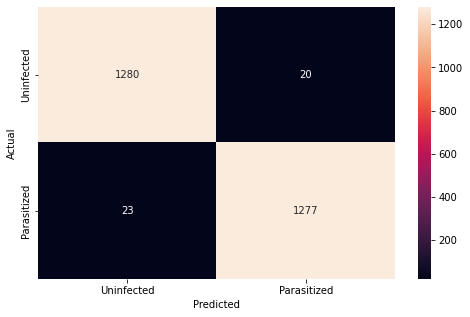

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

The model is **equally accurate in both precision and recall**. If possible we would like to **optimize more for recall** as the cost of false negatives is potentially death, while there is little risk of fasle positives (malaria drugs having minor side effects and it is likely that patients would be tested a second time to confirm)

The model does **not show signs of overfitting** and we can predict it will **generalize well**.

## **Model 1**

###<b> Clear Backend

In [ ]:
backend.clear_session() # Clearing the backend for new model

### **Building model_1**

Noticed that given base model is using **[loss function = binary_crossentropy]**, which works as the 2 output neurons are getting classified independently. However best practice recommends using **[loss function = categorical_crossentropy]** with 2 neuron outputs. 

**Change loss function to categorical cross entropy.**

In [ ]:
# Creating sequential model
model_1 = Sequential()

#Layer 1
model_1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model_1.add(MaxPooling2D(pool_size = 2))
model_1.add(Dropout(0.2))

#Layer 2
model_1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model_1.add(MaxPooling2D(pool_size = 2))
model_1.add(Dropout(0.2))

#Layer 3
model_1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model_1.add(MaxPooling2D(pool_size = 2))
model_1.add(Dropout(0.2))

model_1.add(Flatten())
model_1.add(Dense(512, activation = "relu"))
model_1.add(Dropout(0.4))
model_1.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [ ]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks 

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train our Model

In [ ]:
# Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history = model_1.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 99s 157ms/step - loss: 0.4623 - accuracy: 0.7642 - val_loss: 0.1654 - val_accuracy: 0.9659
Epoch 2/20
624/624 [==============================] - 86s 138ms/step - loss: 0.1244 - accuracy: 0.9574 - val_loss: 0.1441 - val_accuracy: 0.9798
Epoch 3/20
624/624 [==============================] - 89s 143ms/step - loss: 0.0921 - accuracy: 0.9712 - val_loss: 0.0377 - val_accuracy: 0.9932
Epoch 4/20
624/624 [==============================] - 86s 138ms/step - loss: 0.0803 - accuracy: 0.9731 - val_loss: 0.0511 - val_accuracy: 0.9896
Epoch 5/20
624/624 [==============================] - 91s 145ms/step - loss: 0.0736 - accuracy: 0.9758 - val_loss: 0.0709 - val_accuracy: 0.9824


###<b> Plotting the validation and training accuracies

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

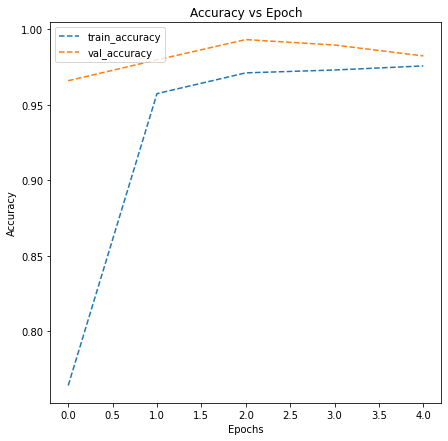

In [ ]:
plot_accuracy(history)

* Model was more **efficient** taking **half the number of epochs** compared to the base model
* **Epoch 3** scored very well on validation accuracy **(99.32%)**. If model_1 turns out to be the best option we should test epoch 3 on the testing accuracy to see if it performs better. 
* Still seeing validation accuracy higher than training accuracy, will try and adress this later with data augmentation.

###<b> Evaluating the model on test data

In [ ]:
accuracy = model_1.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 5s 60ms/step - loss: 0.0691 - accuracy: 0.9785

 Test_Accuracy:- 0.9784615635871887


* Compared to the base model **(test accuracy of 98.35%)** model_1 has a test accuracy of **97.84%** which is comparable.

<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1300
           1       0.98      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



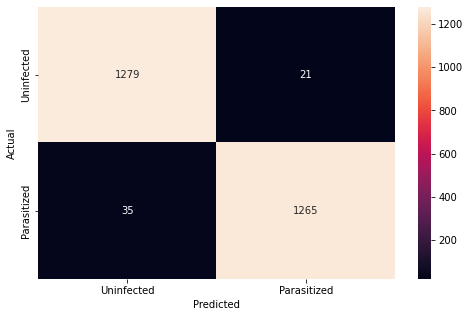

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model_1.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

Similar to the base model, model_1 is equally accurate in both precision and recall. 

Given the model was more **efficient** using **[loss function = categorical_crossentropy]**, performed relatively the same as the base model, and C.C.E. is the recomended loss function with multiple output neurons, we will **use it moving forward**. 

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model.

The model does **not show signs of overfitting** and we can predict it will **generalize well**.

## **Model 2**

### **Model_2**
#### Trying to improve the performance of our model by adding new layers
+ Add a **4rth layer with 64 filters** | kernel size 2 | 'same' padding |
  + Expect the increased complexity to cause some overfitting


In [ ]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model

In [ ]:
# Creating sequential model
model_2 = Sequential()


#Layer 1
model_2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model_2.add(MaxPooling2D(pool_size = 2))
model_2.add(Dropout(0.2))

#Layer 2
model_2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model_2.add(MaxPooling2D(pool_size = 2))
model_2.add(Dropout(0.2))

#Layer 3
model_2.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model_2.add(MaxPooling2D(pool_size = 2))
model_2.add(Dropout(0.2))

#Layer 4 (new)
model_2.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))
model_2.add(MaxPooling2D(pool_size = 2))
model_2.add(Dropout(0.2))

model_2.add(Flatten())
model_2.add(Dense(512, activation = "relu"))
model_2.add(Dropout(0.4))
model_2.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model_2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [ ]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
history = model_2.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 93s 147ms/step - loss: 0.3250 - accuracy: 0.8363 - val_loss: 0.1098 - val_accuracy: 0.9824
Epoch 2/20
624/624 [==============================] - 90s 145ms/step - loss: 0.0960 - accuracy: 0.9674 - val_loss: 0.0676 - val_accuracy: 0.9862
Epoch 3/20
624/624 [==============================] - 90s 144ms/step - loss: 0.0831 - accuracy: 0.9739 - val_loss: 0.0436 - val_accuracy: 0.9904
Epoch 4/20
624/624 [==============================] - 89s 142ms/step - loss: 0.0758 - accuracy: 0.9754 - val_loss: 0.0527 - val_accuracy: 0.9890
Epoch 5/20
624/624 [==============================] - 99s 159ms/step - loss: 0.0731 - accuracy: 0.9763 - val_loss: 0.0689 - val_accuracy: 0.9804


<b> Plotting the train and the validation curves

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

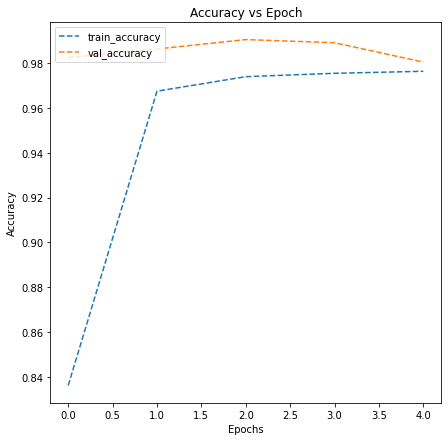

In [ ]:
plot_accuracy(history)

* Again a middle epoch (**Epoch 3**) scored highest on validation accuracy **(99.04%)**. If model_2 turns out to be the best option we should test epoch 3 on the testing accuracy to see if it performs better. 
* Still seeing validation accuracy higher than training accuracy, will try and adress this later with data augmentation.

###<b> Evaluating the model

In [ ]:
accuracy = model_2.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 36ms/step - loss: 0.0645 - accuracy: 0.9808

 Test_Accuracy:- 0.9807692170143127


* Compared to the model_1 **(test accuracy of 97.84%)** model_2 has a test accuracy of **98.07%** a slight increase while again completing at 4 epochs. It would normaly be debatable if the 1% increase is worth the additional complexity, but given that is **1/3 of our optimization goal** we will **keep the extra layer moving forward**.

<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



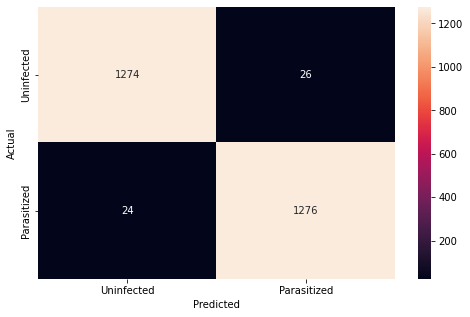

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model_2.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

Similar to the previous models, model_2 is equally accurate in both precision and recall. 

The model does **not show signs of overfitting** and we can predict it will **generalize well**.

## **Model 3**

### **Model 3**
+ Change activation function to **LeakyRelu with slope = 0.1**
+ Add a **batch normalization layers**


In [ ]:
backend.clear_session() # Clearing the backend for new model

###<b> Building the Model

In [ ]:

# Creating sequential model
model_3 = Sequential()

#Layer 1
model_3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", input_shape = (64, 64, 3)))
model_3.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_3.add(MaxPooling2D(pool_size = 2))
model_3.add(Dropout(0.2))

#Layer 2
model_3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))
model_3.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_3.add(MaxPooling2D(pool_size = 2))
model_3.add(Dropout(0.2))

model_3.add(BatchNormalization()) #Add batch normalization 

#Layer 3
model_3.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))
model_3.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_3.add(MaxPooling2D(pool_size = 2))
model_3.add(Dropout(0.2))

model_3.add(BatchNormalization()) #Add batch normalization 

#Layer 4 
model_3.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))
model_3.add(MaxPooling2D(pool_size = 2))
model_3.add(Dropout(0.2))

model_3.add(BatchNormalization()) #Add batch normalization 

model_3.add(Flatten())
model_3.add(Dense(512))
model_3.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_3.add(Dropout(0.4))
model_3.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                      

###<b> Compiling the model

In [ ]:
model_3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
history = model_3.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
624/624 [==============================] - 107s 170ms/step - loss: 0.6007 - accuracy: 0.6969 - val_loss: 0.0074 - val_accuracy: 0.9994
Epoch 2/20
624/624 [==============================] - 105s 168ms/step - loss: 0.1619 - accuracy: 0.9423 - val_loss: 0.0237 - val_accuracy: 0.9950
Epoch 3/20
624/624 [==============================] - 111s 178ms/step - loss: 0.1039 - accuracy: 0.9673 - val_loss: 0.0226 - val_accuracy: 0.9952


<b> Plotting the train and the validation curves

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

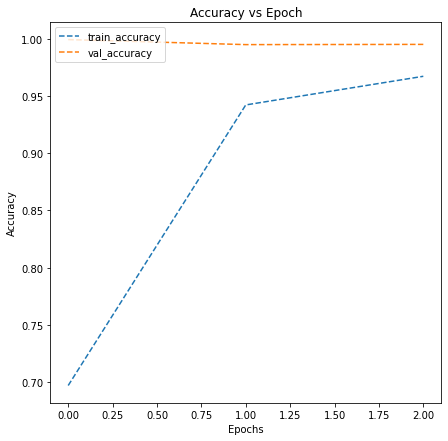

In [ ]:
plot_accuracy(history)

* Model_3 was **even more efficient** completing in effectively 2 epochs
* Even though it terminated at epoch 2 it would seem epoch 3 was very slightly higher. Might want to adjust the early stopping sensitivity as we are fighting for every percentage at this point
* Epoch 1 showed highest validation accuracy at **(99.94%)** but given that our validation accuracy is starting unusually high this might not be reflective in the testing data. 
* Still seeing validation accuracy higher than training accuracy, will try and adress this later with data augmentation.

###<b> Evaluating the model

In [ ]:
accuracy = model_3.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 7s 84ms/step - loss: 0.1259 - accuracy: 0.9623

 Test_Accuracy:- 0.9623076915740967


* Unfortunately the **test accuracy dropped**, compared to the model_2 (test accuracy of **98.07%**) model_3 has a test accuracy of **96.23%** a loss of 2%, which is **significant** at this level of optimization.

<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1300
           1       0.99      0.93      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



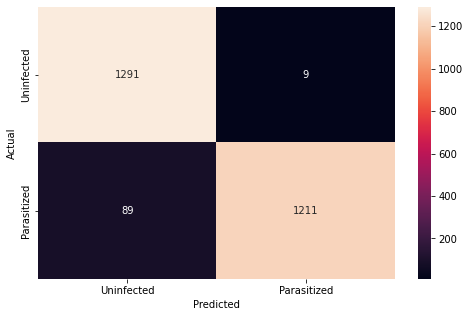

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model_3.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

The addition of  LeakyRelu and Batch Normalization Layers has caused the **test accuracy to drop** while **maintaining training and validation accuracy**. The model is now showing signs of **overfitting**.

Similarly bad the model is now predicting **more false negatives**, and **fewer false positives**; which is in the oposite direction to what we want. That is **precision is being optimized over recall**. 

This is clearly a **step backwards** and we should **return to the structure of model_2**.

## **Model 4**

###<b>Model 4 with Data Augmentation

In [ ]:
backend.clear_session() # Clearing backend for new model

###<b> Using image data generator

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size = 0.2, random_state = 42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images 
# Added vertical flipping, noise, lighting conditions, perspective transformation
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip	= True,
                                   zca_whitening = True,
                                  zoom_range = 0.5, rotation_range = 30)

val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size = 64, seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x = X_val, y = y_val, batch_size = 64, seed = 42, shuffle = True)

###**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

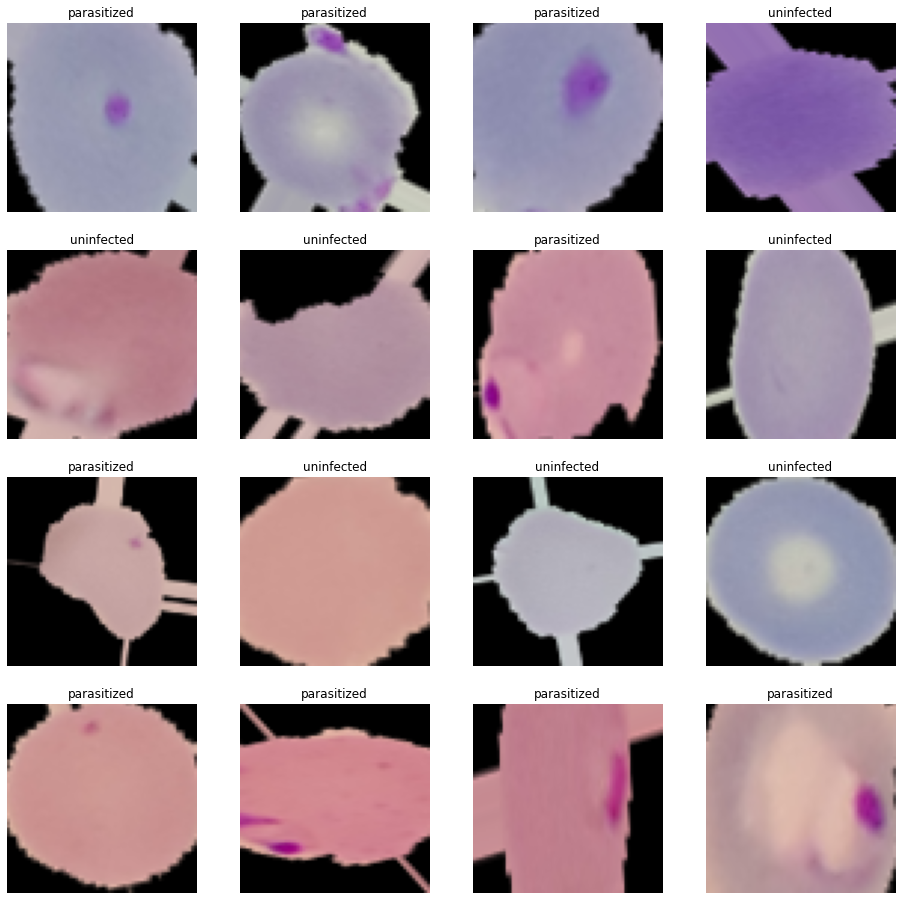

In [ ]:
# Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

# Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))

fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):

    ax.imshow(image)

    if label[1] == 1: 

        ax.set_title('parasitized')

    else:

        ax.set_title('uninfected')

    ax.axis('off')

#### **Observations and insights:**

The images have been stretch and flipped in various ways.

###<b>Building the Model

In [ ]:
model_4 = Sequential()

# Build the model here 
# Using same architechture as model_2 as that is what performed the best
#Layer 1
model_4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model_4.add(MaxPooling2D(pool_size = 2))
model_4.add(Dropout(0.2))

#Layer 2
model_4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model_4.add(MaxPooling2D(pool_size = 2))
model_4.add(Dropout(0.2))

#Layer 3
model_4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model_4.add(MaxPooling2D(pool_size = 2))
model_4.add(Dropout(0.2))

#Layer 4
model_4.add(Conv2D(filters = 64, kernel_size = 2, padding = "same", activation = "relu"))
model_4.add(MaxPooling2D(pool_size = 2))
model_4.add(Dropout(0.2))

model_4.add(Flatten())
model_4.add(Dense(512, activation = "relu"))
model_4.add(Dropout(0.4))
model_4.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

# Use this as the optimizer
adam = optimizers.Adam(learning_rate = 0.001)

model_4.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
history3 = model_4.fit(train_generator, 
                                  validation_data = val_generator,
                                  batch_size = 32, callbacks = callbacks,
                                  epochs = 20, verbose = 1)

Epoch 1/20
312/312 [==============================] - 125s 395ms/step - loss: 0.5929 - accuracy: 0.6643 - val_loss: 0.1773 - val_accuracy: 0.9529
Epoch 2/20
312/312 [==============================] - 115s 369ms/step - loss: 0.2112 - accuracy: 0.9238 - val_loss: 0.1154 - val_accuracy: 0.9696
Epoch 3/20
312/312 [==============================] - 110s 352ms/step - loss: 0.1746 - accuracy: 0.9404 - val_loss: 0.1182 - val_accuracy: 0.9732
Epoch 4/20
312/312 [==============================] - 109s 349ms/step - loss: 0.1654 - accuracy: 0.9450 - val_loss: 0.1015 - val_accuracy: 0.9714
Epoch 5/20
312/312 [==============================] - 110s 353ms/step - loss: 0.1581 - accuracy: 0.9469 - val_loss: 0.0844 - val_accuracy: 0.9734
Epoch 6/20
312/312 [==============================] - 109s 349ms/step - loss: 0.1557 - accuracy: 0.9470 - val_loss: 0.0843 - val_accuracy: 0.9716
Epoch 7/20
312/312 [==============================] - 122s 391ms/step - loss: 0.1533 - accuracy: 0.9475 - val_loss: 0.0946 -

* Took longer to compile with more epochs, not surprising given the data augmentation

###<B>Evaluating the model

<b>Plot the train and validation accuracy

In [ ]:
# Potting the accuracies
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")


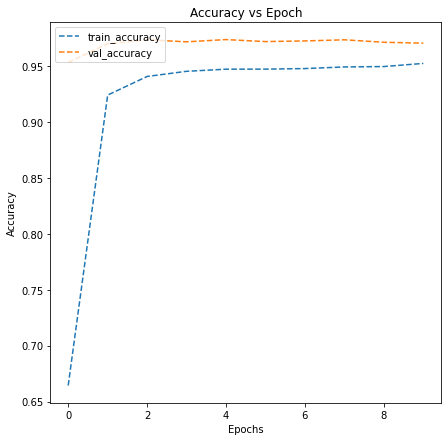

In [ ]:
plot_accuracy(history3)

* The **validation accuracy is still slightly higher than the train accuracy**. This means that the **data augmentation** did not solve the **High regularization**.
* Model seems to have stalled out at around 97% validation accuracy. 

In [ ]:
# Evaluating the model on test data
accuracy3 = model_4.evaluate(test_images, test_labels, verbose = 1)

print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 4s 42ms/step - loss: 0.0793 - accuracy: 0.9773

 Test_Accuracy:- 0.9773076772689819


* Compared to our best model model_2 **(test accuracy of 98.07%)** model_4 has a test accuracy of **97.73%** is a slight set back.

<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1300
           1       0.98      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



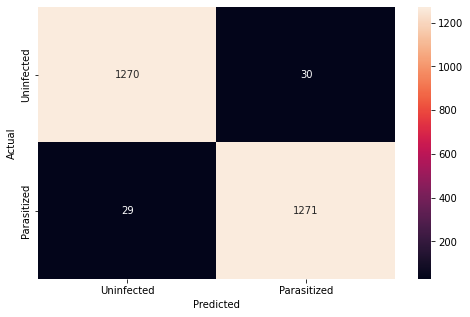

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model_4.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

Similar to the previous models, model_4 is equally accurate in both precision and recall. 

The model does **not show signs of overfitting** and we can predict it will **generalize well**. But it is **not an improvement on model_2** and the data augmentation **failed to solve the issue of high validation_accuracy**.

We can hypothesis that data augmentation is specifically usefull for combating the **large variation found in real world**. However our data set contains images that are to a degree **controled to be similar** (taken from the same angle, the same size, of red blood cells of the same relative composition). Therefore it makes sense that data augmentation would **not be very impactfull here**. 

<b> Now, let us try to use a pretrained model like VGG16 and check how it performs on our data.

## **Model 5**

### **Model_5 - Pre-trained model (VGG16)** 

In [ ]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras import Model

vgg = VGG16(include_top = False , weights = 'imagenet', input_shape = (64, 64, 3))

vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
transfer_layer = vgg.get_layer('block5_pool')

vgg.trainable = False

# Add classification layers on top of it  
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the VGG16 model

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons
x = BatchNormalization()(x)

pred = Dense(2, activation = 'softmax')(x)

model_5 = Model(vgg.input, pred) # Initializing the model

###<b>Compiling the model

In [ ]:
# Compiling the model 
model_5.compile(loss = 'categorical_crossentropy',
                
              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),

              metrics = ['accuracy'])

<b> using callbacks

In [ ]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
# Fitting the model and running the model for 10 epochs
history4 = model_5.fit(
            train_images, train_labels,
            epochs = 20,
            callbacks = callbacks,
            batch_size = 32,
            validation_split = 0.2,
            verbose = 1
)

Epoch 1/20
624/624 [==============================] - 1122s 2s/step - loss: 0.2460 - accuracy: 0.8989 - val_loss: 0.3945 - val_accuracy: 0.8413
Epoch 2/20
624/624 [==============================] - 1084s 2s/step - loss: 0.1788 - accuracy: 0.9293 - val_loss: 0.2169 - val_accuracy: 0.9105
Epoch 3/20
624/624 [==============================] - 1129s 2s/step - loss: 0.1716 - accuracy: 0.9339 - val_loss: 0.2671 - val_accuracy: 0.8984
Epoch 4/20
624/624 [==============================] - 1078s 2s/step - loss: 0.1651 - accuracy: 0.9362 - val_loss: 0.1250 - val_accuracy: 0.9503
Epoch 5/20
624/624 [==============================] - 1075s 2s/step - loss: 0.1527 - accuracy: 0.9407 - val_loss: 0.1860 - val_accuracy: 0.9301
Epoch 6/20
624/624 [==============================] - 1071s 2s/step - loss: 0.1520 - accuracy: 0.9429 - val_loss: 0.1539 - val_accuracy: 0.9449


* Took **significantly** longer to compile

<b>Plot the train and validation accuracy

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

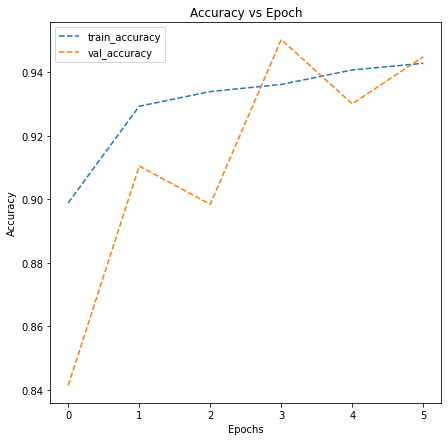

In [ ]:
plot_accuracy(history4)

###**Observations and insights:**
* Both the training accuracy and the validation accuracy are increasing. 
* **Epoch 4** scored highest on validation accuracy **(95.03%)**. 
* Validation accuracy has dropped to a standard start.

###<b> Evaluating the model

In [ ]:
# Evaluating the model on test data
accuracy = model_5.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 118s 1s/step - loss: 0.1751 - accuracy: 0.9269

 Test_Accuracy:- 0.9269230961799622


* Compared to the model_2 **(test accuracy of 98.07%)** model_5 has dropped significantly to a test accuracy of **92.69%** 

<b>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.97      0.89      0.92      1300
           1       0.89      0.97      0.93      1300

    accuracy                           0.93      2600
   macro avg       0.93      0.93      0.93      2600
weighted avg       0.93      0.93      0.93      2600



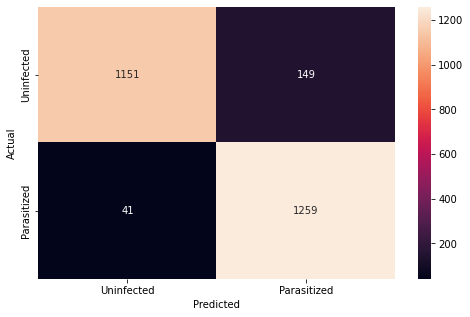

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
pred = model_5.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

Implementing **transfer learning** has caused the **training and validation accuracy to drop** and **test accuracy to drop** even lower. The model is now **overfitted**.

The model is now predicting **more false positives**, and **fewer false negatives**; which is in the direction to what we want (that is **recall is being optimized over precision**). 

Overal the model is a significant step backwards, therefore model_2 is still the best option.

## **Model 2 - Optimized**

### **Building - Model_2o**
#### Try to optimize our best performing model by testing multiple micro adjustments


In [ ]:
backend.clear_session() # Clearing the backend for new model

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

###<b> Building the Model

In [ ]:
# Creating sequential model
model_2o = Sequential()

#Layer 1
model_2o.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", input_shape = (64, 64, 3)))
model_2o.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_2o.add(MaxPooling2D(pool_size = 2))
model_2o.add(Dropout(0.2))

#Layer 2
model_2o.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))
model_2o.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_2o.add(MaxPooling2D(pool_size = 2))
model_2o.add(Dropout(0.2))

#Layer 3
model_2o.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))
model_2o.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_2o.add(MaxPooling2D(pool_size = 2))
model_2o.add(Dropout(0.2))

#Layer 4
model_2o.add(Conv2D(filters = 64, kernel_size = 2, padding = "same"))
model_2o.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_2o.add(MaxPooling2D(pool_size = 2))
model_2o.add(Dropout(0.2))

model_2o.add(Flatten())
model_2o.add(Dense(512))
model_2o.add(LeakyReLU(0.1)) #change to LeakyRelu slope = 0.1
model_2o.add(Dropout(0.4))
model_2o.add(Dense(2, activation = "softmax")) # 2 represents output layer neurons 

model_2o.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                        

###<b> Compiling the model

In [ ]:
model_2o.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
history = model_2o.fit(train_images, train_labels, batch_size = 16, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20
1248/1248 [==============================] - 112s 89ms/step - loss: 0.2437 - accuracy: 0.8870 - val_loss: 0.1257 - val_accuracy: 0.9796
Epoch 2/20
1248/1248 [==============================] - 109s 87ms/step - loss: 0.0925 - accuracy: 0.9704 - val_loss: 0.0654 - val_accuracy: 0.9834
Epoch 3/20
1248/1248 [==============================] - 111s 89ms/step - loss: 0.0850 - accuracy: 0.9733 - val_loss: 0.0831 - val_accuracy: 0.9788
Epoch 4/20
1248/1248 [==============================] - 109s 87ms/step - loss: 0.0830 - accuracy: 0.9743 - val_loss: 0.0636 - val_accuracy: 0.9842
Epoch 5/20
1248/1248 [==============================] - 111s 89ms/step - loss: 0.0765 - accuracy: 0.9749 - val_loss: 0.0492 - val_accuracy: 0.9852
Epoch 6/20
1248/1248 [==============================] - 111s 89ms/step - loss: 0.0754 - accuracy: 0.9765 - val_loss: 0.0478 - val_accuracy: 0.9860
Epoch 7/20
1248/1248 [==============================] - 109s 88ms/step - loss: 0.0692 - accuracy: 0.9770 - val_loss: 0

<b> Plotting the train and the validation curves

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

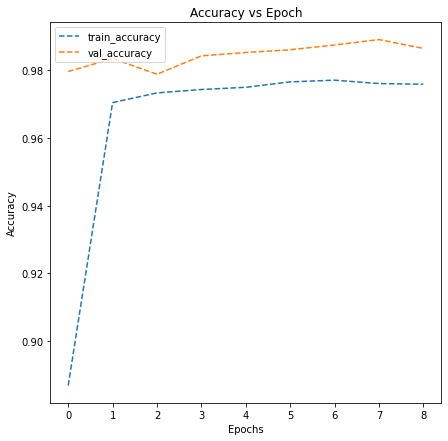

In [ ]:
plot_accuracy(history)

###<b> Evaluating the model

In [ ]:
accuracy = model_2o.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 4s 43ms/step - loss: 0.0468 - accuracy: 0.9869

 Test_Accuracy:- 0.986923098564148


* Compared to the model_2 **(test accuracy of 98.07%)** model_2o has a test accuracy of **98.69%** a slight increase. 
* It bears repeating that given the magnitude of the potential application that small improvement still has tremendose potential impact

<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.99      0.98      0.99      1300

    accuracy                           0.99      2600
   macro avg       0.99      0.99      0.99      2600
weighted avg       0.99      0.99      0.99      2600



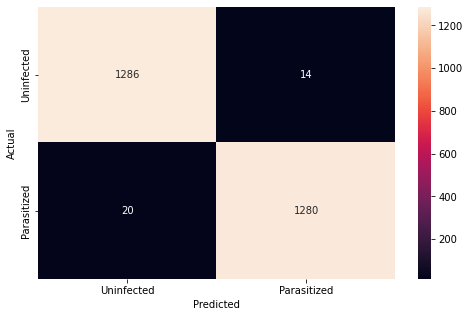

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model_2o.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

Similar to the previous models, model_2o is equally accurate in both precision and recall. 

The model does **not show signs of overfitting** and we can predict it will **generalize well**.

#### **Observations and Conclusions drawn from the final model:**
Through tuning model_2 we found that:
+ The model did in fact perform well with LeakyRelu (likely it was batchnormalization that caused the accuracy drop in previous attemps)
+ Further **increasing complexity slightly improved accuracy**
+ A smaller batch size generally showed higher accuracy



## **Saving**

### **Save as .H5**

In [ ]:
model = model_2o  # Get model (Sequential, Functional Model, or Model subclass)
model.save('my_model.h5')

### **Save as .tflite**

In [ ]:
model = model_2o  # Get model (Sequential, Functional Model, or Model subclass)
model.save('my_model_tf.tflite')

# **Appendix - Other Attempted Models**

### **Model 4** 
+ output layer of 1


In [ ]:
backend.clear_session() # Clearing the backend for new model

###<B>Redo One Hot Encoding on the train and test labels for single node output

In [ ]:
# Encoding Train Labels
train_labels = to_categorical(train_labels, 1)

# Similarly let us try to encode test labels
test_labels = to_categorical(test_labels, 1)

train_labels


IndexError: ignored

###<b> Building the Model

In [ ]:
# Creating sequential model
model_4 = Sequential()


#Layer 1
model_4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model_4.add(MaxPooling2D(pool_size = 2))
model_4.add(Dropout(0.2))

#Layer 2
model_4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model_4.add(MaxPooling2D(pool_size = 2))
model_4.add(Dropout(0.2))

#Layer 3
model_4.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model_4.add(MaxPooling2D(pool_size = 2))
model_4.add(Dropout(0.2))

model_4.add(Flatten())
model_4.add(Dense(512, activation = "relu"))
model_4.add(Dropout(0.4))
model_4.add(Dense(1, activation = "sigmoid")) # 2 represents output layer neurons 

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

###<b> Compiling the model

In [ ]:
model_4.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
history = model_4.fit(train_images, train_labels, batch_size = 32, callbacks = callbacks, validation_split = 0.2, epochs = 20, verbose = 1)

Epoch 1/20


ValueError: ignored

<b> Plotting the train and the validation curves

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

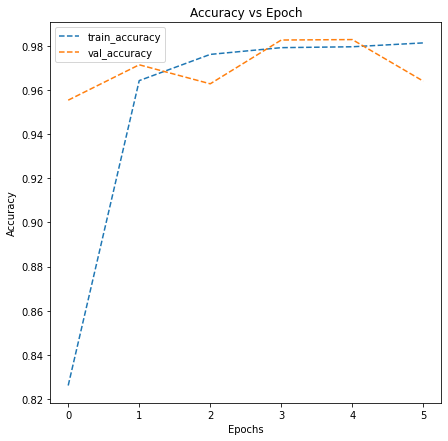

In [ ]:
plot_accuracy(history)

###<b> Evaluating the model

In [ ]:
accuracy = model_4.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 5s 56ms/step - loss: 0.2035 - accuracy: 0.9350

 Test_Accuracy:- 0.9350000023841858


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1300
           1       0.98      0.88      0.93      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.93      2600
weighted avg       0.94      0.94      0.93      2600



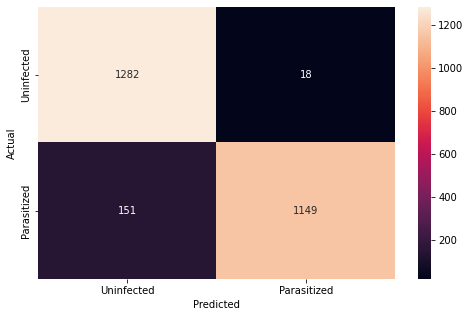

In [ ]:
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

pred = model_4.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

### **Model_6 - Pre-trained model (EfficientNetB0)** 

In [ ]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB1 

from tensorflow.keras import Model

enet = EfficientNetB1(include_top = False , weights = 'imagenet', input_shape = (64, 64, 3))

enet.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 64, 64, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 64, 64, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 65, 65, 3)    0           ['normalization[0][0]']          
                    

In [ ]:
transfer_layer = enet.get_layer('top_activation')

enet.trainable = False

# Add classification layers on top of it  
x = Flatten()(transfer_layer.output)  # Flatten the output from the 3rd block of the EfficientNetB0 model

x = Dense(256, activation = 'relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons
x = BatchNormalization()(x)

pred = Dense(2, activation = 'softmax')(x)

model_6 = Model(enet.input, pred) # Initializing the model

###<b>Compiling the model

In [ ]:
# Compiling the model 
model_6.compile(loss = 'categorical_crossentropy',
                
              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),

              metrics = ['accuracy'])

<b> using callbacks

In [ ]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
# Fitting the model and running the model for 10 epochs
history5 = model_6.fit(
            train_images, train_labels,
            epochs = 20,
            callbacks = callbacks,
            batch_size = 32,
            validation_split = 0.2,
            verbose = 1
)

Epoch 1/20
624/624 [==============================] - 169s 270ms/step - loss: 0.6626 - accuracy: 0.6301 - val_loss: 1.0349 - val_accuracy: 0.0000e+00
Epoch 2/20
624/624 [==============================] - 180s 289ms/step - loss: 0.6613 - accuracy: 0.6301 - val_loss: 1.0250 - val_accuracy: 0.0000e+00
Epoch 3/20
624/624 [==============================] - 169s 272ms/step - loss: 0.6614 - accuracy: 0.6301 - val_loss: 1.0110 - val_accuracy: 0.0000e+00
Epoch 4/20
624/624 [==============================] - 166s 266ms/step - loss: 0.6620 - accuracy: 0.6301 - val_loss: 1.0103 - val_accuracy: 0.0000e+00
Epoch 5/20
624/624 [==============================] - 190s 305ms/step - loss: 0.6616 - accuracy: 0.6302 - val_loss: 1.0747 - val_accuracy: 0.0000e+00
Epoch 6/20
624/624 [==============================] - 179s 287ms/step - loss: 0.6609 - accuracy: 0.6302 - val_loss: 1.0281 - val_accuracy: 0.0000e+00


<b>Plot the train and validation accuracy

In [ ]:
# Function to plot train and validation accuracy 
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), history.history["accuracy"], label = "train_accuracy", ls = '--')

    plt.plot(np.arange(0, N), history.history["val_accuracy"], label = "val_accuracy", ls = '--')

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

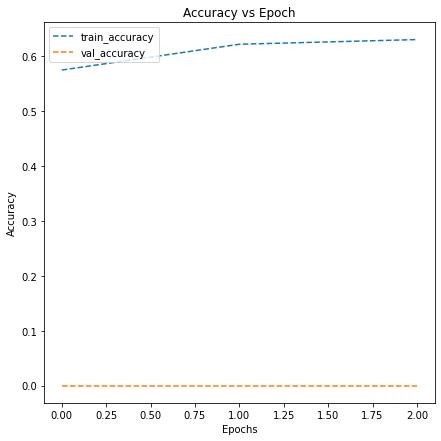

In [ ]:
plot_accuracy(history5)

###**Observations and insights:**

*   What can be observed from the validation and train curves?
* Again a middle epoch (**Epoch 3**) scored highest on validation accuracy **(99.04%)**. If model_2 turns out to be the best option we should test epoch 3 on the testing accuracy to see if it performs better. 
* Still seeing validation accuracy higher than training accuracy, will try and adress this later with data augmentation.

###<b> Evaluating the model

In [ ]:
# Evaluating the model on test data
accuracy = model_6.evaluate(test_images, test_labels, verbose = 1)
print('\n', 'Test_Accuracy:-', accuracy[1])

* Compared to the model_1 **(test accuracy of 97.84%)** model_2 has a test accuracy of **98.07%** a slight increase while again completing at 4 epochs. It would normaly be debatable if the 1% increase is worth the additional complexity, but given that is **1/3 of our optimization goal** we will **keep the extra layer moving forward**.

<b>Plotting the classification report and confusion matrix

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
pred = model_6.predict(test_images)

pred = np.argmax(pred, axis = 1) 

y_true = np.argmax(test_labels, axis = 1)

# Printing the classification report
print(classification_report(y_true, pred))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)

plt.figure(figsize = (8, 5))

sns.heatmap(cm, annot = True,  fmt = '.0f', xticklabels = ['Uninfected', 'Parasitized'], yticklabels = ['Uninfected', 'Parasitized'])

plt.ylabel('Actual')

plt.xlabel('Predicted')

plt.show()

Similar to the previous models, model_2 is equally accurate in both precision and recall. 

The model does **not show signs of overfitting** and we can predict it will **generalize well**.